# Forecasting the outflow of clients from the TeleDom company.

## Introduction:

### *Project Description:*
    TeleDom telecom operator wants to combat customer churn. TeleDom needs a model that will predict whether a subscriber will terminate a contract. The operator's team collected personal data on some clients, information about their tariffs and services.
### *Project Goal:*
    Train a model to predict customer churn based on the provided data.
### *Data Description:*
    Contract_new.csv table (contract information):
        - customerID — subscriber identifier;
        - BeginDate — contract start date;
        - EndDate — contract end date;
        - Type — payment type: once a year or twice a year or monthly;
        - PaperlessBilling — electronic payslip;
        - PaymentMethod — payment type;
        - MonthlyCharges — monthly expenses;
        - TotalCharges — subscriber's total expenses.

    Table personal_new.csv (customer's personal data):
        - customerID — user identifier;
        - gender — gender;
        - SeniorCitizen — whether the subscriber is a pensioner;
        - Partner — whether the subscriber has a spouse;
        - Dependents — whether the subscriber has children.

    Table internet_new.csv (information about Internet services):
        - customerID — user identifier;
        - InternetService — connection type;
        - OnlineSecurity — blocking dangerous sites;
        - OnlineBackup — cloud storage of files for data backup;
        - DeviceProtection — antivirus;
        - TechSupport — dedicated technical support line;
        - StreamingTV — streaming television;
        - StreamingMovies — movie catalog.

    Table phone_new.csv (information about telephony services):
        - customerID — user identifier;
        - MultipleLines — connecting the phone to several lines simultaneously.

### *Work plan:*
    Step 1. Loading data:
        - load the data
        - perform their initial inspection.
    Step 2. Exploratory analysis and data preprocessing
        - perform exploratory analysis of each data frame and, if necessary, perform preprocessing
    Step 3. Combining data
        - combine the selected features into one data frame by key.
    Step 4. Exploratory analysis and preprocessing of the combined data frame
        - perform exploratory analysis of the combined data frame
        - visualize the distribution of features and, if necessary, perform preprocessing
        - conduct correlation analysis.
        - draw conclusions about the available features: will they be needed for training the models.
    Step 5. Preparing data
        - prepare the data for training the model.
        - divide the data into two samples
    Step 6. Training machine learning models
        - train the models
        - select hyperparameters
    Step 7. Selecting the best model
        - select the best model
        - check its quality on the test sample.

In [1]:
# ! pip install -q phik
# ! pip install -q category_encoders
# ! pip install --upgrade -q scikit-learn
# ! pip install -q lightgbm
# ! pip install -q catboost

In [2]:
# IMPORTING LIBRARIES
# Standard Libraries
import os
import warnings

# Base
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Analysis
from scipy.stats import shapiro, probplot
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Data preparation + search
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, \
OrdinalEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from category_encoders import TargetEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay

## Loading data

### Loading

In [3]:
path_local = ['/datasets/contract_new.csv','/datasets/personal_new.csv','/datasets/internet_new.csv',\
              '/datasets/phone_new.csv']
path_server = list(map(lambda x: 'https://code.s3.yandex.net' + x, path_local))

flag = 1
for i in path_local:
    if not os.path.exists(i):
        flag = 0
        break

if flag:
    df_contract_new = pd.read_csv(path_local[0])
    df_personal_new = pd.read_csv(path_local[1])
    df_internet_new = pd.read_csv(path_local[2])
    df_phone_new = pd.read_csv(path_local[3])
else:
    df_contract_new = pd.read_csv(path_server[0])
    df_personal_new = pd.read_csv(path_server[1])
    df_internet_new = pd.read_csv(path_server[2])
    df_phone_new = pd.read_csv(path_server[3])     

### Initial inspection

In [4]:
dict_df = {'Table contract_new.csv': df_contract_new,
           'Table personal_new.csv': df_personal_new,
           'Table internet_new.csv': df_internet_new,
           'Table  phone_new.csv': df_phone_new
          }
for key, value in dict_df.items():
    display(value.head().style.set_caption(key))
    print('\n')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850000,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950000,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.850000,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300000,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.700000,353.5


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


All the declared features are present, but the target feature is missing. We have to extract it ourselves. You can bring the column names to the usual snake_case style

In [5]:
reg_from = '([a-z])([A-Z])'
reg_to = r'\1_\2'

for i in [df_contract_new, df_personal_new, df_internet_new, df_phone_new]:
    i.columns = [re.sub(reg_from, reg_to, i.columns[j]).lower() \
                    for j in range(len(i.columns))]

In [6]:
for i in dict_df.values():
    display(i.info(), i.describe(include='all'))
    print('\n'*2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customer_id,gender,senior_citizen,partner,dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


It seems that there are no empty values, but you can see that the data type of the `total_charges` attribute in the `df_contract_new` table is `object`, although `float` was expected. It is worth examining the contents of this attribute, and apparently the contents of the other attributes.

### *Conclusion:*
- all features are present
- target feature must be selected
- Null values ​​are not observed
- feature names have been brought to snake_case style
- we have noticed an incorrect data type for the total_charges feature in the df_contract_new table, we will fix this and study the contents of the remaining features

## Exploratory analysis and data preprocessing

### Checking data for correctness

In [7]:
start = '\033[1m'
end = '\033[0m'
for key, value in dict_df.items():
    print(f'{start}{key}{end}')
    for i in value:
        if value[i].dtypes == 'object':
            print(f'\t- {i}: {value[i].unique()}')
    print('\n')

Table contract_new.csv
	- customer_id: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
	- begin_date: ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2

No abnormal values ​​were found in the data, but it is worth studying the `total_charges` feature separately.

When trying to convert this feature to the `float` type, an error occurred related to the content of a gap in the data.

In [8]:
df_contract_new[df_contract_new['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Expenses must be specified, since there is no contract end date, but there are expenses for the month. Note that all customers with gaps in the `total_charges` column are new customers who paid the subscription fee on 2020.02.01. It would be logical to fill in the empty values ​​in `total_charges` with the values ​​from `monthly_charges`.

In [9]:
df_contract_new.loc[df_contract_new['total_charges'] == ' ', \
                    'total_charges'] = (df_contract_new
                                        .loc[df_contract_new['total_charges'] == ' ', 'monthly_charges']
                                       )

df_contract_new['total_charges'] = df_contract_new['total_charges'].astype(float)

### Check for duplicates

In [10]:
print('Obvious duplicates')
for key, value in dict_df.items():
    print(f'{key}: {value.duplicated().sum()}')

Obvious duplicates
Table contract_new.csv: 0
Table personal_new.csv: 0
Table internet_new.csv: 0
Table  phone_new.csv: 0


There are no obvious duplicates

In [11]:
print('Duplicates by id')
for key, value in dict_df.items():
    print(f'{key}: {value["customer_id"].duplicated().sum()}')

Duplicates by id
Table contract_new.csv: 0
Table personal_new.csv: 0
Table internet_new.csv: 0
Table  phone_new.csv: 0


Duplicates by id were also not found

### *Conclusion:*
- replaced spaces in the `total_charges` attribute with the corresponding values ​​in the `total_changes` column, since the clients are new
- no duplicates found

## Data Merging

### An association

Let's join all tables by the `customer_id` column.

In [12]:
df_all_info = df_contract_new.merge(df_internet_new, on='customer_id', how='left')
df_all_info = df_all_info.merge(df_personal_new, on='customer_id', how='left')
df_all_info = df_all_info.merge(df_phone_new, on='customer_id', how='left')

In [13]:
df_all_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   internet_service   5517 non-null   object 
 9   online_security    5517 non-null   object 
 10  online_backup      5517 non-null   object 
 11  device_protection  5517 non-null   object 
 12  tech_support       5517 non-null   object 
 13  streaming_tv       5517 non-null   object 
 14  streaming_movies   5517 non-null   object 
 15  gender             7043 non-null   object 
 16  senior_citizen     7043 

After the merger, gaps naturally appeared, and these were related to the connected services; most likely, they were caused by the fact that some clients simply did not use Internet services or telephone services.

### *Conclusion:*
- merged all tables by the `customer_id` column
- a large number of gaps appeared

## Exploratory analysis and preprocessing of the combined dataframe data

### Working with passes

In [14]:
df_all_info[df_all_info['internet_service'].isna()].loc[:, 'internet_service':'streaming_movies']

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
7017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7030,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that if NaN is in the features related to Internet services, then it is in all of them. What is no less important is that NaN is in the feature `internet_service`. This means that these clients do not use the Internet at all, and not just have not connected to some individual services. Let's try to fill these gaps with the value `unknown`, which will indicate that there is no data. Perhaps we will allow our model to find some new patterns. We could fill the gaps in the columns with the value No (where possible), but then this can be interpreted as if the client did not buy the service, but connected to the Internet. We will do the same with the column `multiple_lines`.

In [15]:
df_all_info.fillna('out_of_service', inplace=True)

In [16]:
df_all_info.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64

Just in case, let's check the data again for duplicates after merging and filling in the gaps.

In [17]:
print('Obvious duplicates')
for key, value in dict_df.items():
    print(f'{key}: {value.duplicated().sum()}')

Obvious duplicates
Table contract_new.csv: 0
Table personal_new.csv: 0
Table internet_new.csv: 0
Table  phone_new.csv: 0


There are no duplicates

### Creating a target feature

Let's extract the target feature from the `end_date` feature. If `end_date` contains `No`, then the contract has not been terminated yet, and we will designate such clients as 0. If `end_date` contains some date, then the contract has been terminated, and we will designate such clients as 1.

In [18]:
df_all_info['sub_status'] = df_all_info['end_date'].apply(lambda x: 1 if x != 'No' else 0)

After creating a target feature based on `end_date`, there will be a leak of the target feature through all absolute dates, so it makes sense to remove the `end_date` and `begin_date` features.

### Creating new input features

Let's create a `remaining_days_payment` attribute, which will reflect the number of days remaining under the contract.

First, let's convert the `begin_date` attribute to the datetime type

In [19]:
df_all_info['begin_date'] = pd.to_datetime(df_all_info['begin_date'])

Let's create a new feature

In [20]:
# Functions that calculate the number of days remaining under the contract,
# depending on the type of payment and the date of the contract  
date = pd.to_datetime('2020-02-01')

def count_days(x, new_date, date, n, m):
    if new_date >= date:
        days = n + abs((date - new_date).days)
    else:
        days = m - abs((date - new_date).days)
        
    return days

def remaining_days(x):
    new_date = x['begin_date'].replace(year=2020)
    
    if x['type'] == 'One year':
        days = count_days(x, new_date, date, 0, 365)
            
    elif x['type'] == 'Two year':
        if x['begin_date'].year % 2 == 0:
            days = count_days(x, new_date, date, 0, 730)
        else:
            days = count_days(x, new_date, date, 365, 365)
    else:
        days = 30
    return days


In [21]:
df_all_info['remaining_days_payment'] = df_all_info.apply(remaining_days, axis=1)

Let's add a feature that will reflect the number of days completed under the contract.

In [22]:
df_all_info.loc[df_all_info['end_date'] == 'No', 'end_date'] = date
df_all_info['end_date'] = pd.to_datetime(df_all_info['end_date'])
df_all_info['days_passed'] = (df_all_info['end_date'] - df_all_info['begin_date']).apply(lambda x: x.days)

In [23]:
df_all_info[['begin_date', 'end_date', 'type', 'remaining_days_payment', 'days_passed']].head(20)

,begin_date,end_date,type,remaining_days_payment,days_passed
0,2020-01-01,2020-02-01,Month-to-month,30,31
1,2017-04-01,2020-02-01,One year,60,1036
2,2019-10-01,2020-02-01,Month-to-month,30,123
3,2016-05-01,2020-02-01,One year,90,1371
4,2019-09-01,2020-02-01,Month-to-month,30,153
5,2019-03-01,2020-02-01,Month-to-month,30,337
6,2018-04-01,2020-02-01,Month-to-month,30,671
7,2019-04-01,2020-02-01,Month-to-month,30,306
8,2017-07-01,2020-02-01,Month-to-month,30,945
9,2014-12-01,2017-05-01,One year,304,882


Let's remove the `end_date` and `begin_date` flags to avoid leakage.

In [24]:
df_all_info = df_all_info.drop(['end_date', 'begin_date'], axis=1)

### Research Analysis

Secondary functions

In [25]:
def control_of_analysis_graphs(df, df_2, column, xlabel, title, \
                               range_size_hist=(0, 0), bins=25, \
                               hist=True, shapiro=True, label=['Did NOT terminate the contract', 'The contract was broken']):
        
    # we build graphs
    if hist:
        plt.figure(figsize=(15, 5));
        plt.suptitle(title, fontweight='bold', fontsize=16)
        hist_print(df, df_2, range_size_hist, xlabel, bins, column, label)
        qqplot_print(df, df_2, column, xlabel, label)
    boxplot_print(df, df_2, column, label)
    
    # We conduct the Shapiro-Wilk test
    if shapiro:
        shapiro_test(df, df_2, column)

Plotting a histogram

In [26]:
def hist_print(df, df_2, range_size, xlabel, bins, column, label):
    sns.kdeplot(df[column], label=label[0])
    sns.kdeplot(df_2[column], label=label[1])
    plt.legend()
    plt.grid()
    plt.title('Distribution of values')
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel('Distribution density', fontsize=13)
    plt.show()

Shapiro-Wilk test

In [27]:
def shapiro_test(df, df_2, column):
    shapiro_result = shapiro(df[column])
    shapiro_result_2 = shapiro(df_2[column])
    if shapiro_result[1] >= 0.05:
        print(f'Distribution of values ​​of clients,',
              f'who did NOT terminate the contract is normal, p-value= {shapiro_result[1]}')
    else:
        print(f'Distribution of values ​​of clients,',
              f'who did NOT terminate the contract is not normal, p-value = {shapiro_result[1]}' )
    if shapiro_result_2[1] >= 0.05:
        print(f'Distribution of values ​​of clients,',
              f'who terminated the contract is normal, p-value = {shapiro_result_2[1]}')
    else:
        print(f'Distribution of values ​​of clients,',
              f'who terminated the contract is not normal, p-value = {shapiro_result_2[1]}' )

Building a boxplot

In [28]:
def boxplot_print(df, df_2, column, label):
    plt.figure(figsize=(15, 5));
    ax = plt.subplot()
    ax.boxplot([df[column], df_2[column]])
    ax.set_xticklabels(label)
    plt.title('Scatter plot')
    plt.grid()
    plt.show()

Building a Q-Q plot

In [29]:
def qqplot_print(df, df_2, column, ylabel, label):
    plt.figure(figsize=(15, 5));
    plt.subplot(1, 2, 1)
    probplot(df[column], plot=plt);
    plt.ylabel(ylabel)
    plt.title(label[0])
    plt.xlabel('Theoretical quantiles')
    
    plt.subplot(1, 2, 2)
    probplot(df_2[column], plot=plt);
    plt.ylabel(ylabel)
    plt.title(label[1])
    plt.xlabel('Theoretical quantiles')
    plt.show()

Plotting Pie Charts

In [30]:
def pie_print(df, columns, title):
    wp = { 'linewidth' : 2, 'edgecolor' : "white" }
    pivot = df.pivot_table(index='sub_status', columns=columns, values='customer_id', aggfunc='count')
    axes = pivot.plot(kind='pie', autopct='%1.0f%%', ylabel='', \
                      wedgeprops = wp, subplots=True, figsize=(12,5), legend=False, title=title)
    for i in range(len(pivot.columns)):
        axes[i].set_title(pivot.columns[i])
    plt.show()

#### Payment type

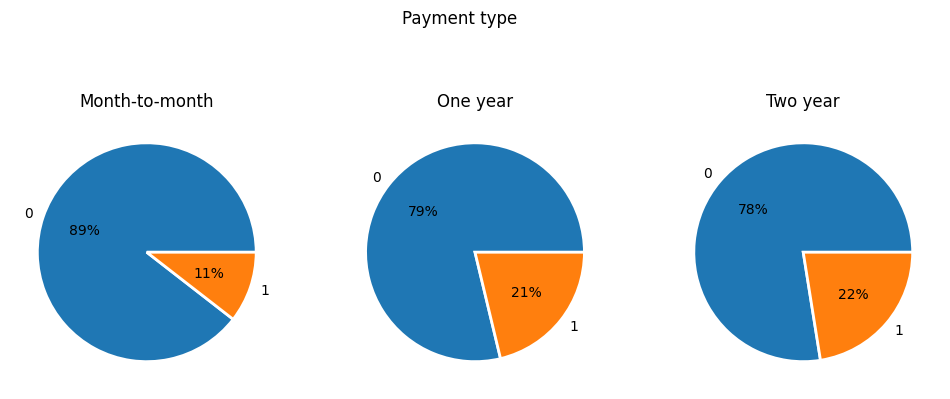

In [31]:
pie_print(df_all_info, 'type', 'Payment type')

Approximately the same percentage of clients who terminated the contract among those who concluded a contract for 1 year or for 2 years. Most likely, this is due to the fact that clients are not ready to endure for a long time until the end of the contract and decide to terminate it, unlike clients with a monthly contract.

#### Electronic payslip

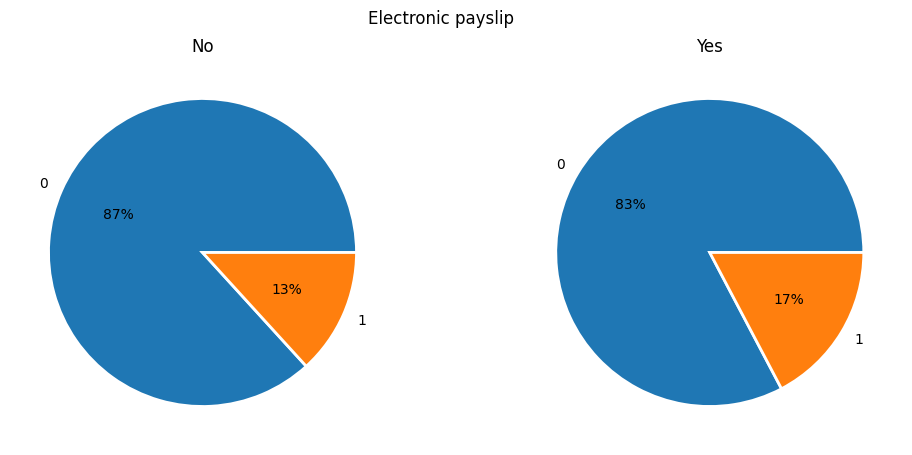

In [32]:
pie_print(df_all_info, 'paperless_billing', 'Electronic payslip')

A higher percentage of clients who terminated their contracts were among those who had an electronic payslip.

Clients who had an electronic payslip were more likely to terminate the contract.

#### Payment method

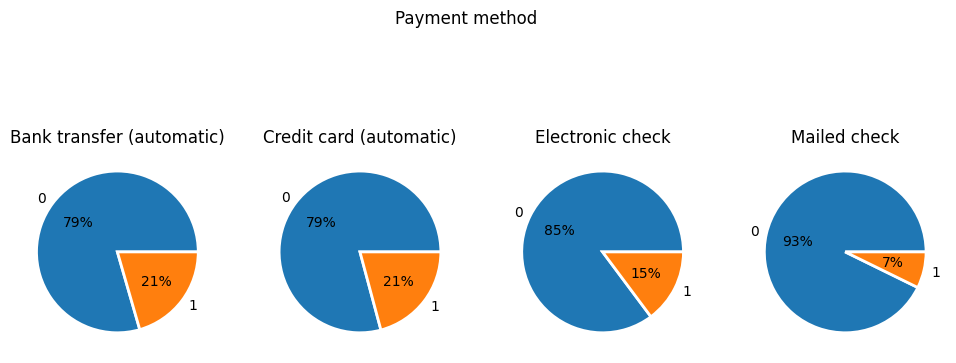

In [33]:
pie_print(df_all_info, 'payment_method', 'Payment method')

The highest percentage of clients who terminated their contracts were those who used bank transfer or credit card. It is important to note that this payment apparently occurred automatically, and it is possible that many extensions occurred accidentally for those clients who forgot to cancel the automatic extension.

#### Expenses for the month

In [34]:
RANDOM_STATE = 22072024

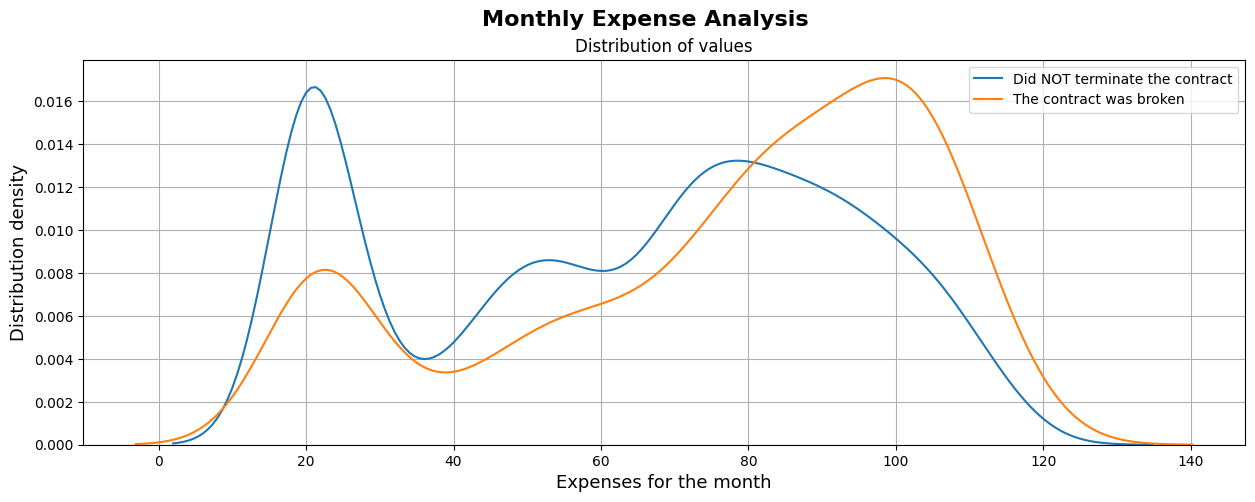

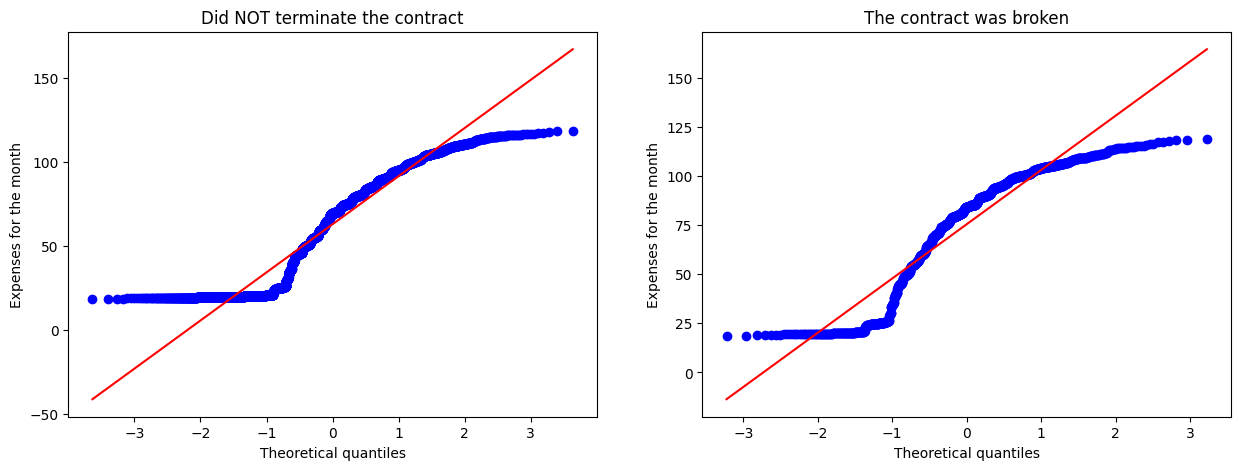

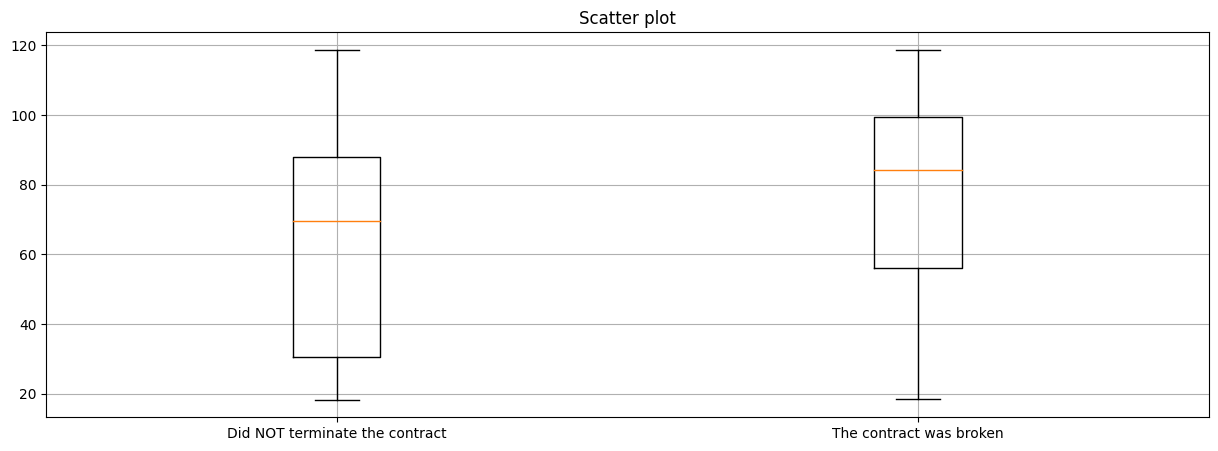

Distribution of values ​​of clients, who did NOT terminate the contract is not normal, p-value = 4.203895392974451e-45
Distribution of values ​​of clients, who terminated the contract is not normal, p-value = 1.7239521244411066e-26


In [35]:
control_of_analysis_graphs(df_all_info[df_all_info['sub_status'] == 0].sample(5000, random_state=RANDOM_STATE), \
                           df_all_info[df_all_info['sub_status'] == 1], 'monthly_charges', \
                           'Expenses for the month', 'Monthly Expense Analysis')

Note that the clients who terminated the contract paid more per month on average than the clients who did NOT terminate the contract. About 70 on average for those who did NOT terminate and about 85 for those who did terminate, with the peak for those who terminated being at 100.

Both distributions are abnormal, judging by the graphs and the Shapiro-Wilk test.

We will use PowerTransformer at the data preparation stage to normalize the distributions.

#### Total subscriber expenses

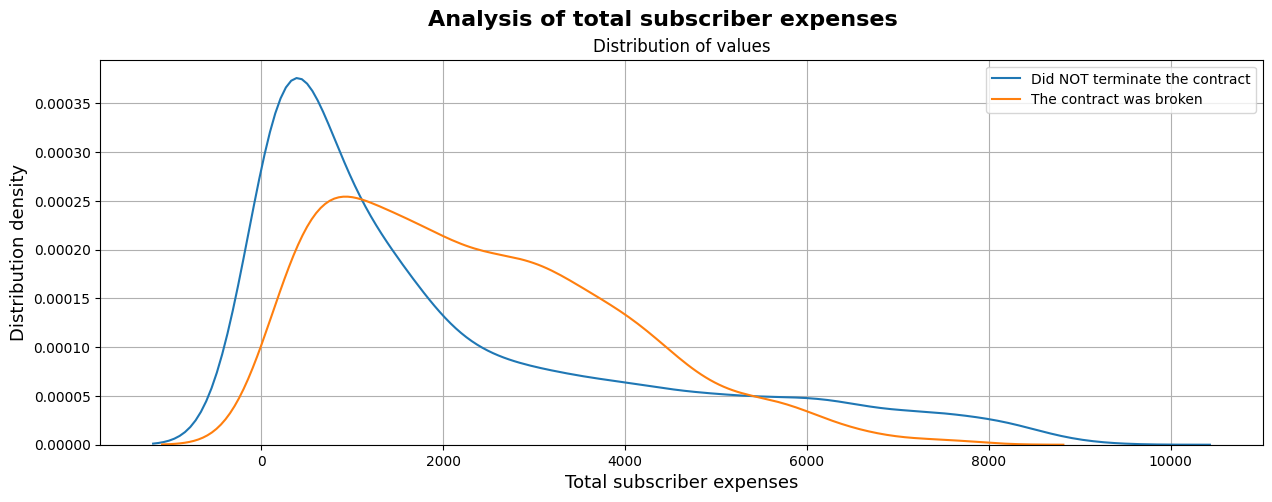

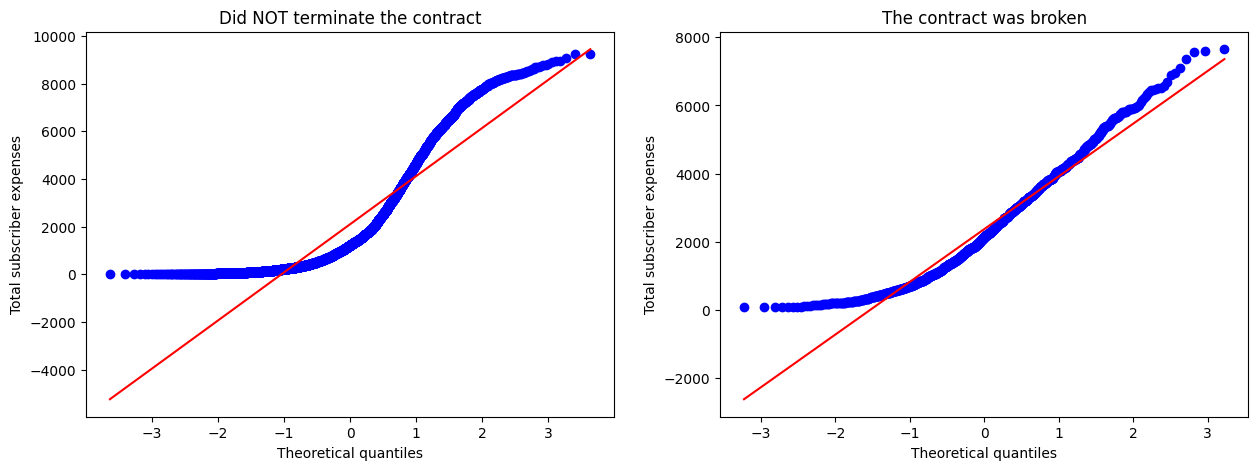

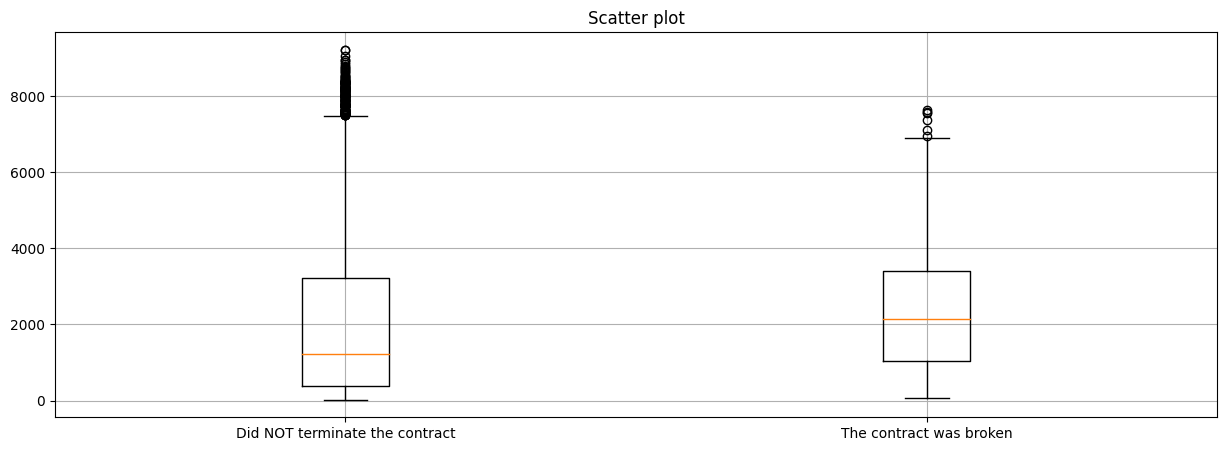

Distribution of values ​​of clients, who did NOT terminate the contract is not normal, p-value = 0.0
Distribution of values ​​of clients, who terminated the contract is not normal, p-value = 1.0826285647676989e-18


In [36]:
control_of_analysis_graphs(df_all_info[df_all_info['sub_status'] == 0].sample(5000, random_state=RANDOM_STATE), \
                           df_all_info[df_all_info['sub_status'] == 1], 'total_charges', \
                           'Total subscriber expenses', \
                           'Analysis of total subscriber expenses')

The total expenses of the clients who terminated the contract are also higher than those of those who did not terminate the contract.

The distributions are also abnormal

#### Client gender

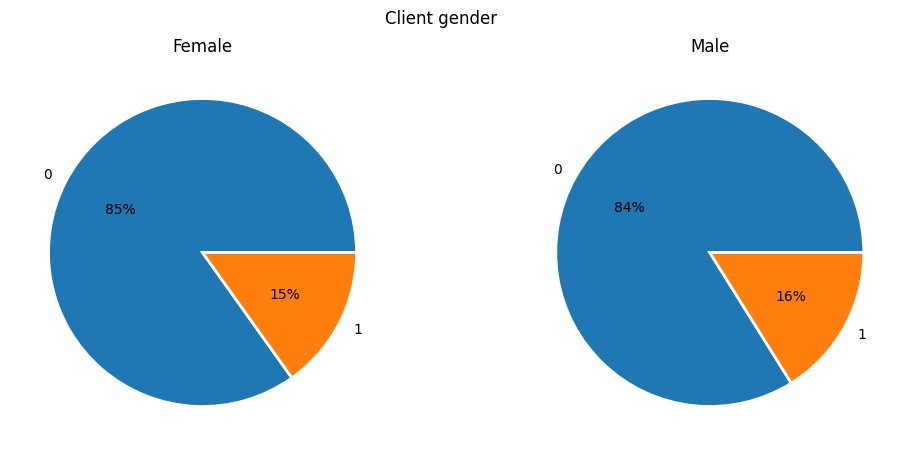

In [37]:
pie_print(df_all_info, 'gender', 'Client gender')

Judging by the pie charts, the termination of the contract does not depend much on the gender of the client. Since both men and women terminate the contract with approximately the same percentage of the total.

#### Is the client a pensioner?

Let's transform the values ​​of this feature by analogy with other categorical features to the form Yes/No

In [38]:
df_all_info['senior_citizen'] = df_all_info['senior_citizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

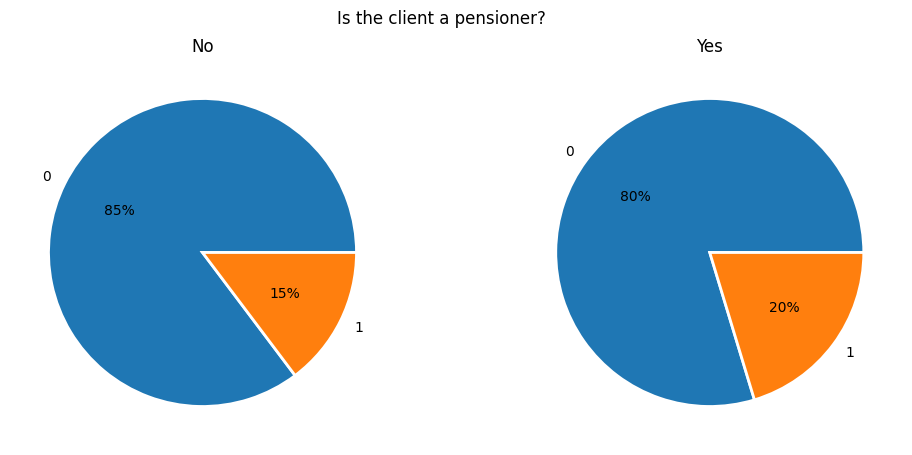

In [39]:
pie_print(df_all_info, 'senior_citizen', 'Is the client a pensioner?')

20% of all pensioners terminate the contract, and 15% of all NON-pensioners terminate the contract. This means that the client who terminated the contract is slightly more likely to be a pensioner.

#### Do you have a husband or wife?

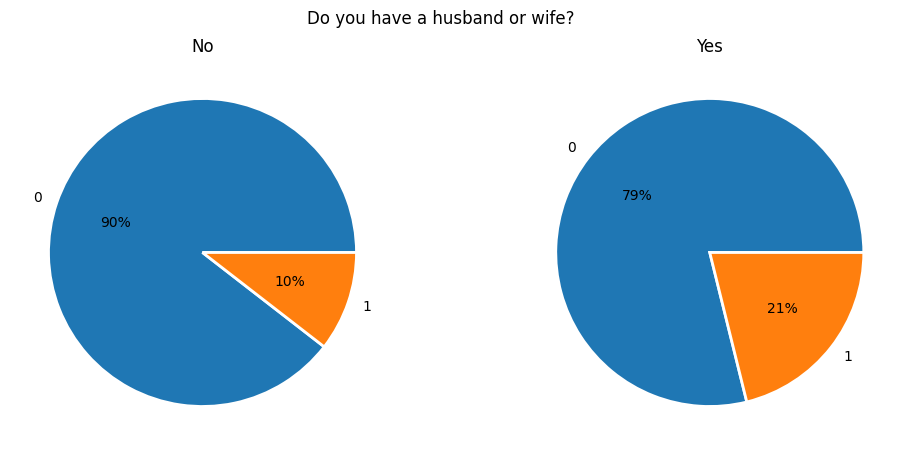

In [40]:
pie_print(df_all_info, 'partner', 'Do you have a husband or wife?')

Примечательно, что клиенты с супругом или супругой с большей долей разрывают договор, чем клиенты без второй половинки.

#### Are there any children?

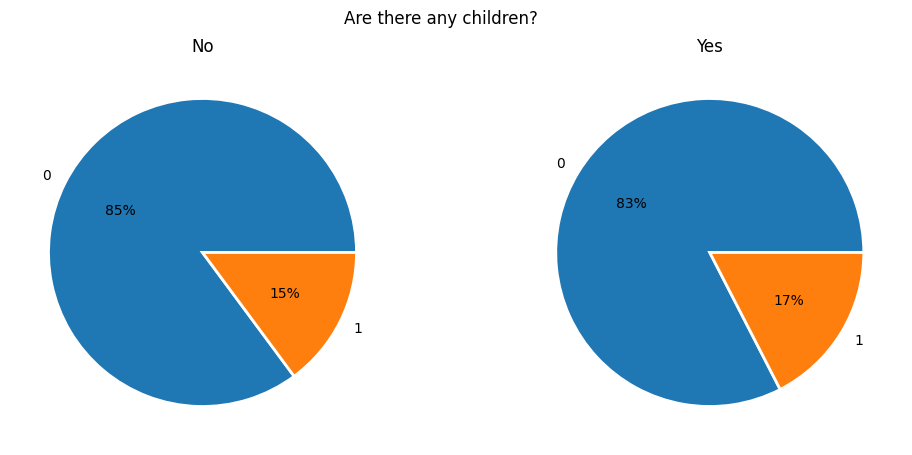

In [41]:
pie_print(df_all_info, 'dependents', 'Are there any children?')

The percentage of those who terminated their contracts was slightly higher among those who have children.

#### Internet connection type

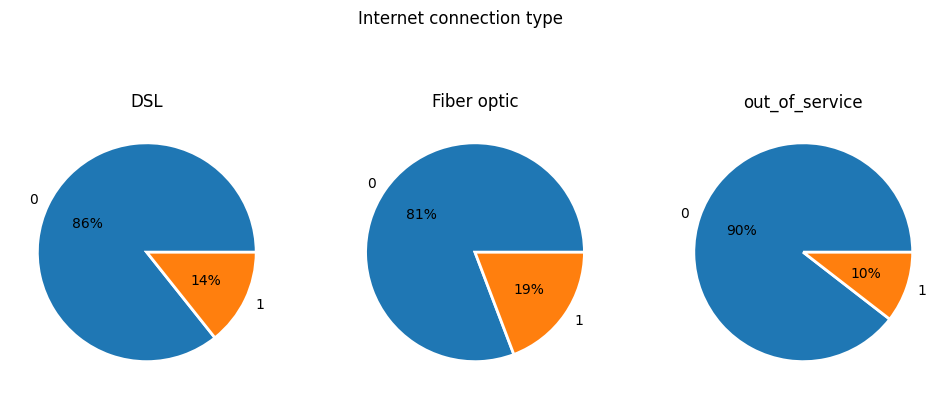

In [42]:
pie_print(df_all_info, 'internet_service', 'Internet connection type')

It is interesting that among those who use fiber optic cable, the percentage of those who terminated the contract is the highest. And the smallest percentage is among those who do not use Internet services at all.

#### Is there a blocking of dangerous sites?

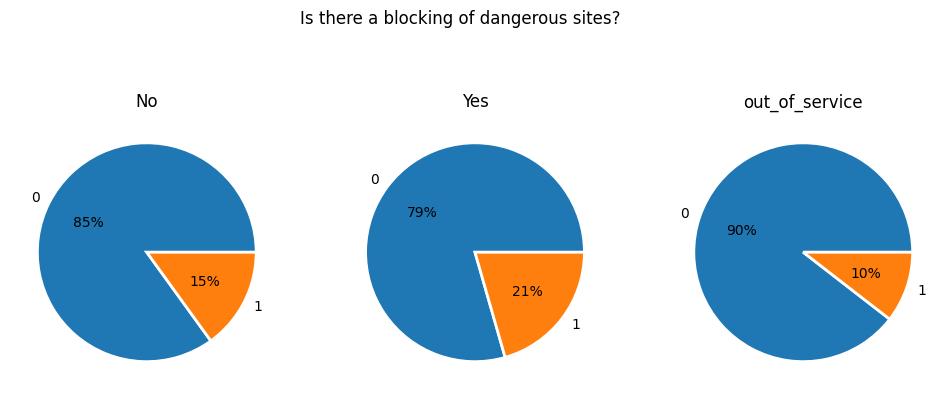

In [43]:
pie_print(df_all_info, 'online_security', 'Is there a blocking of dangerous sites?')

And again we see the same situation. More people who terminated their contracts were among those who used the service of blocking dangerous sites.

#### Is there cloud storage

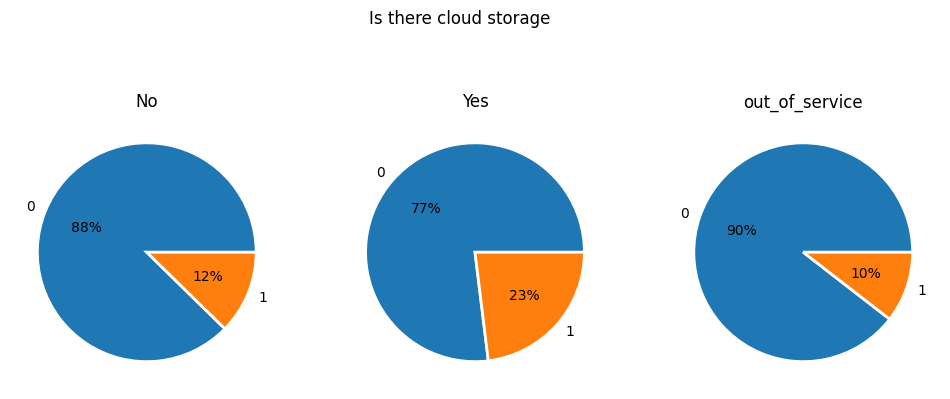

In [44]:
pie_print(df_all_info, 'online_backup', 'Is there cloud storage')

#### Is there an antivirus?

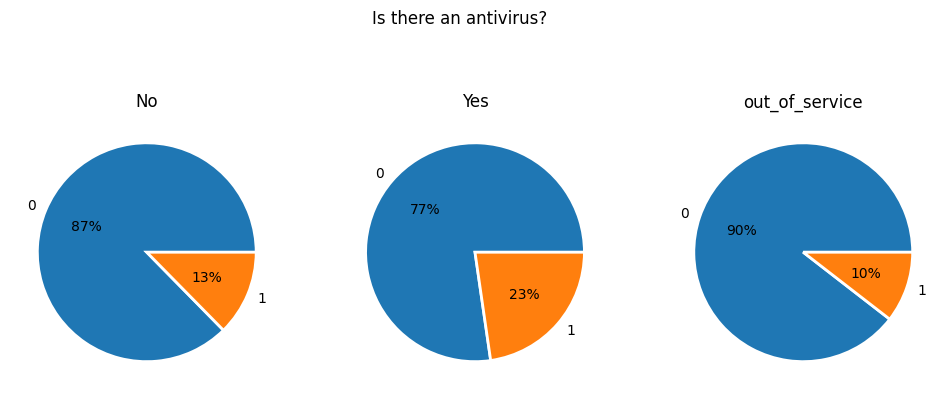

In [45]:
pie_print(df_all_info, 'device_protection', 'Is there an antivirus?')

#### Is there a dedicated tech support line?

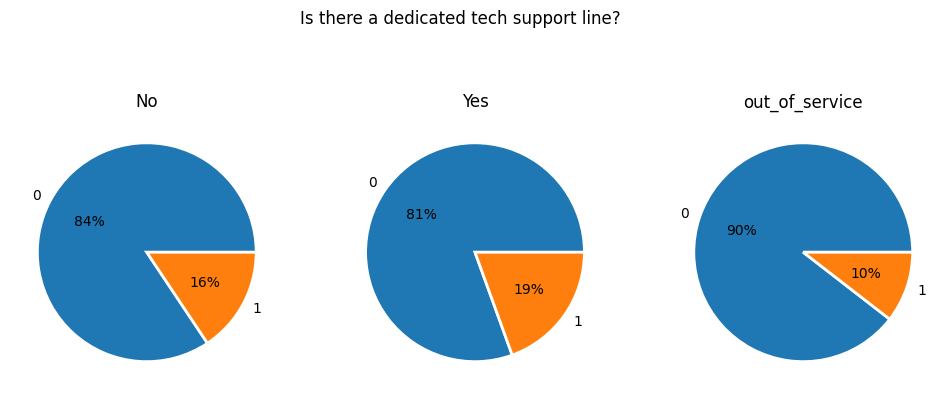

In [46]:
pie_print(df_all_info, 'tech_support', 'Is there a dedicated tech support line?')

#### Is there streaming television

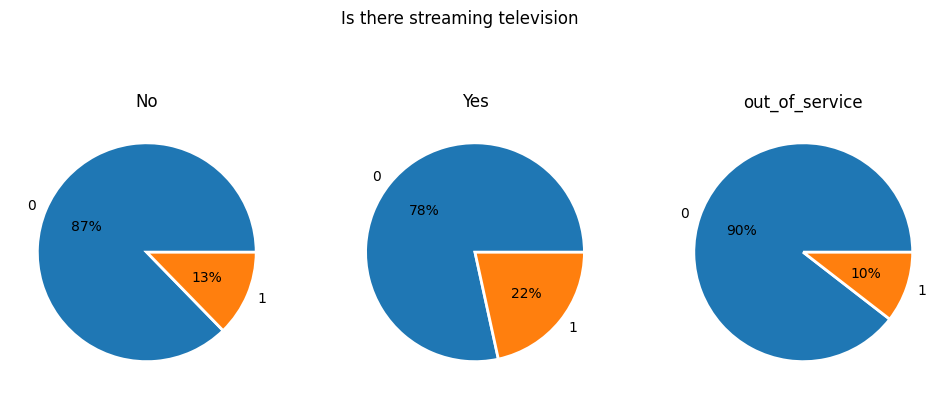

In [47]:
pie_print(df_all_info, 'streaming_tv', 'Is there streaming television')

#### Is there a catalog of films

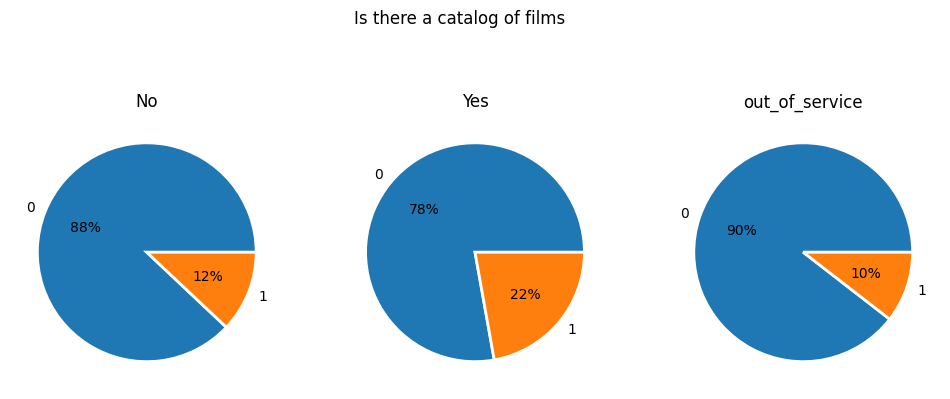

In [48]:
pie_print(df_all_info, 'streaming_movies', 'Is there a catalog of films')

#### Is there a phone connection to multiple lines

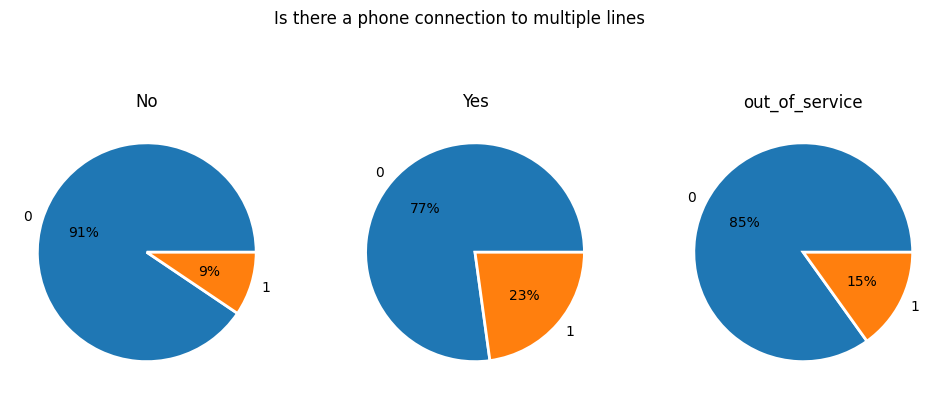

In [49]:
pie_print(df_all_info, 'multiple_lines', 'Is there a phone connection to multiple lines')

**Approximately the same situation with all additional services. Among those who use these services, there are more clients who terminate the contract. Perhaps this is due to their low quality and, as a result, dissatisfaction with them, but for an additional fee. We saw that clients who terminated the contract paid more on average. This is confirmed by the pie charts.**

#### Number of days remaining under the contract

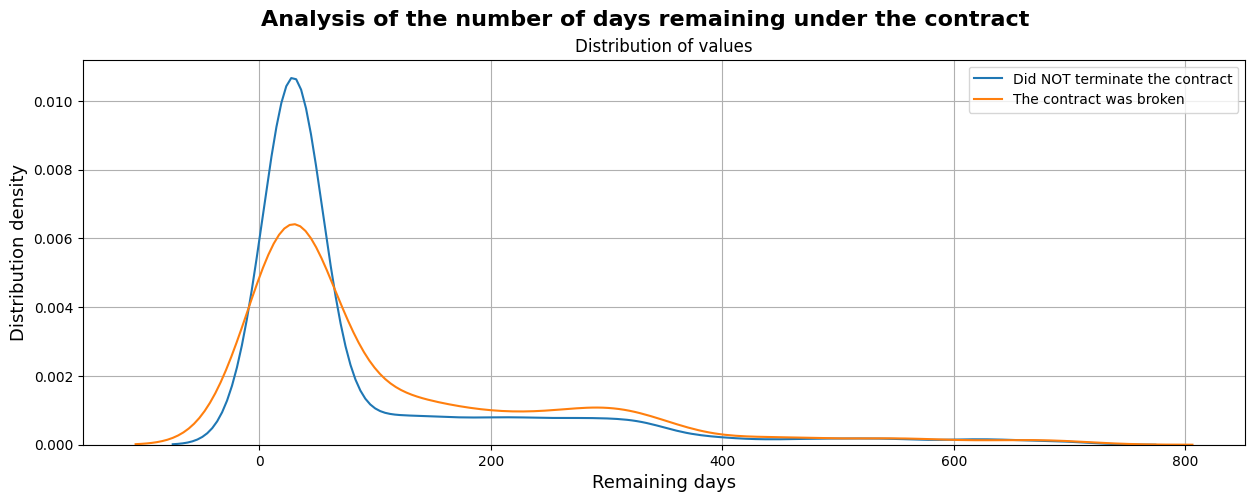

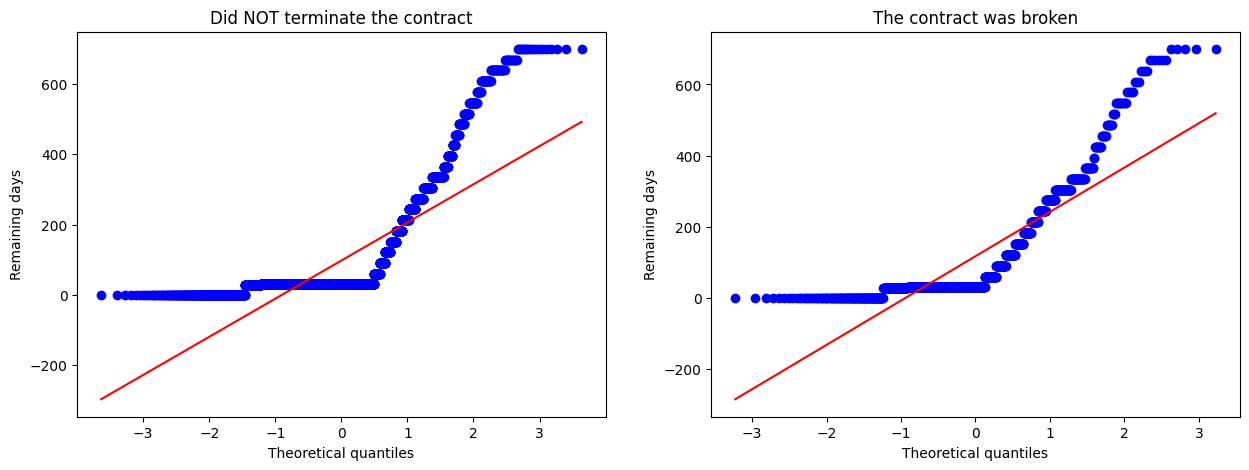

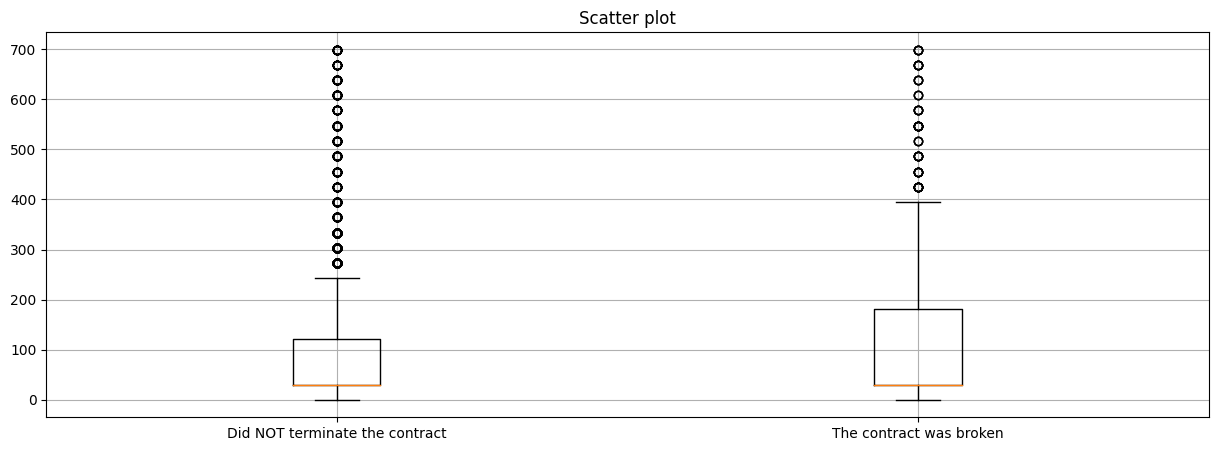

Distribution of values ​​of clients, who did NOT terminate the contract is not normal, p-value = 0.0
Distribution of values ​​of clients, who terminated the contract is not normal, p-value = 1.7044717692888806e-38


In [50]:
control_of_analysis_graphs(df_all_info[df_all_info['sub_status'] == 0].sample(5000, random_state=RANDOM_STATE), \
                           df_all_info[df_all_info['sub_status'] == 1], 'remaining_days_payment', \
                           'Remaining days', \
                           'Analysis of the number of days remaining under the contract')

There are some outliers, we will not remove them.
The distribution is not normal.

#### Number of days passed since the conclusion of the contract

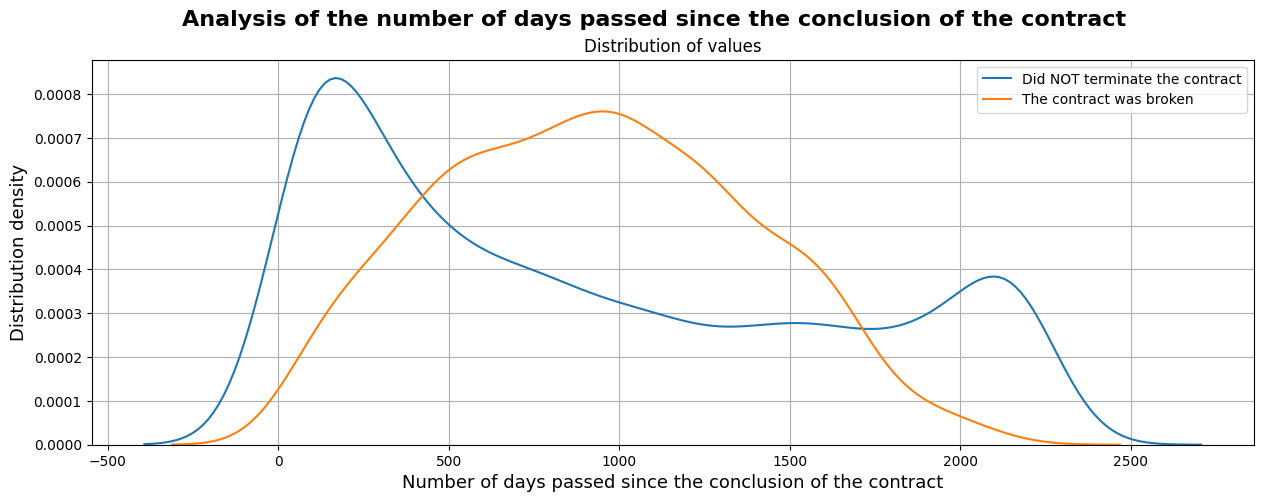

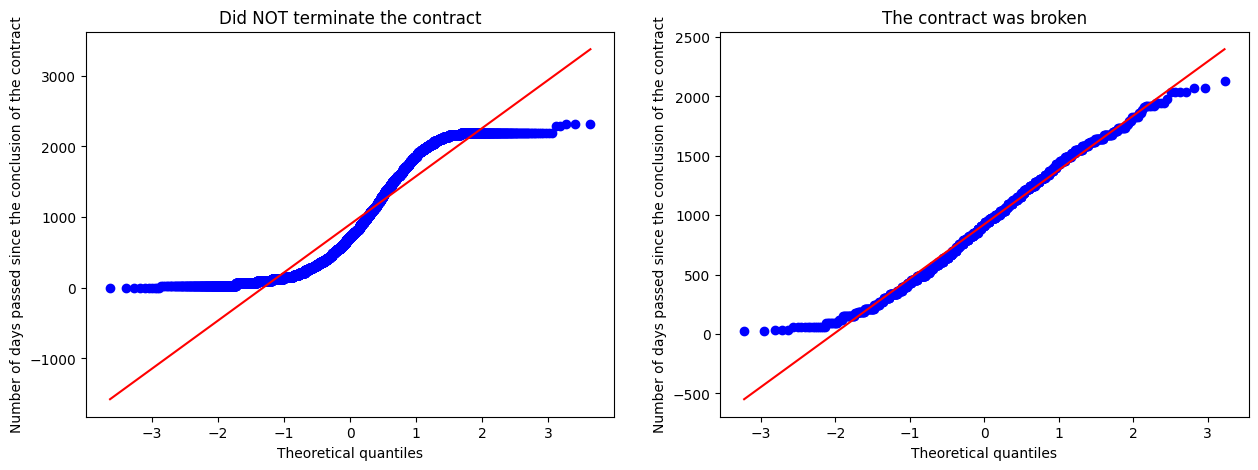

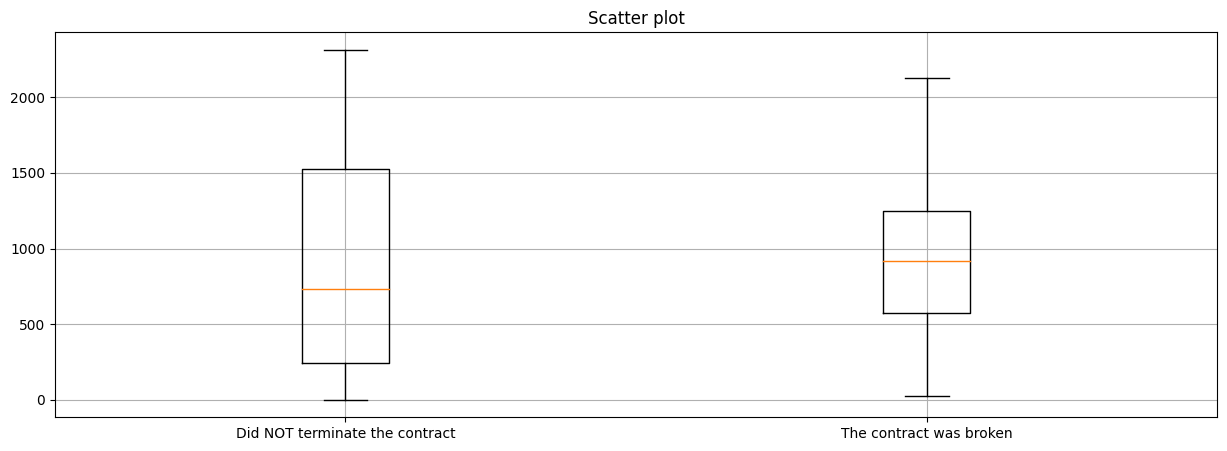

Distribution of values ​​of clients, who did NOT terminate the contract is not normal, p-value = 0.0
Distribution of values ​​of clients, who terminated the contract is not normal, p-value = 7.419177272538491e-09


In [51]:
control_of_analysis_graphs(df_all_info[df_all_info['sub_status'] == 0].sample(5000, random_state=RANDOM_STATE), \
                           df_all_info[df_all_info['sub_status'] == 1], 'days_passed', \
                           'Number of days passed since the conclusion of the contract', \
                           'Analysis of the number of days passed since the conclusion of the contract')

The number of days since the conclusion of the contract is, on average, slightly higher for clients who terminated the contract.

### Correlation analysis

Let's set `customer_id` as indexes.

In [52]:
df_all_info = df_all_info.set_index('customer_id')

Let's conduct a correlation analysis.

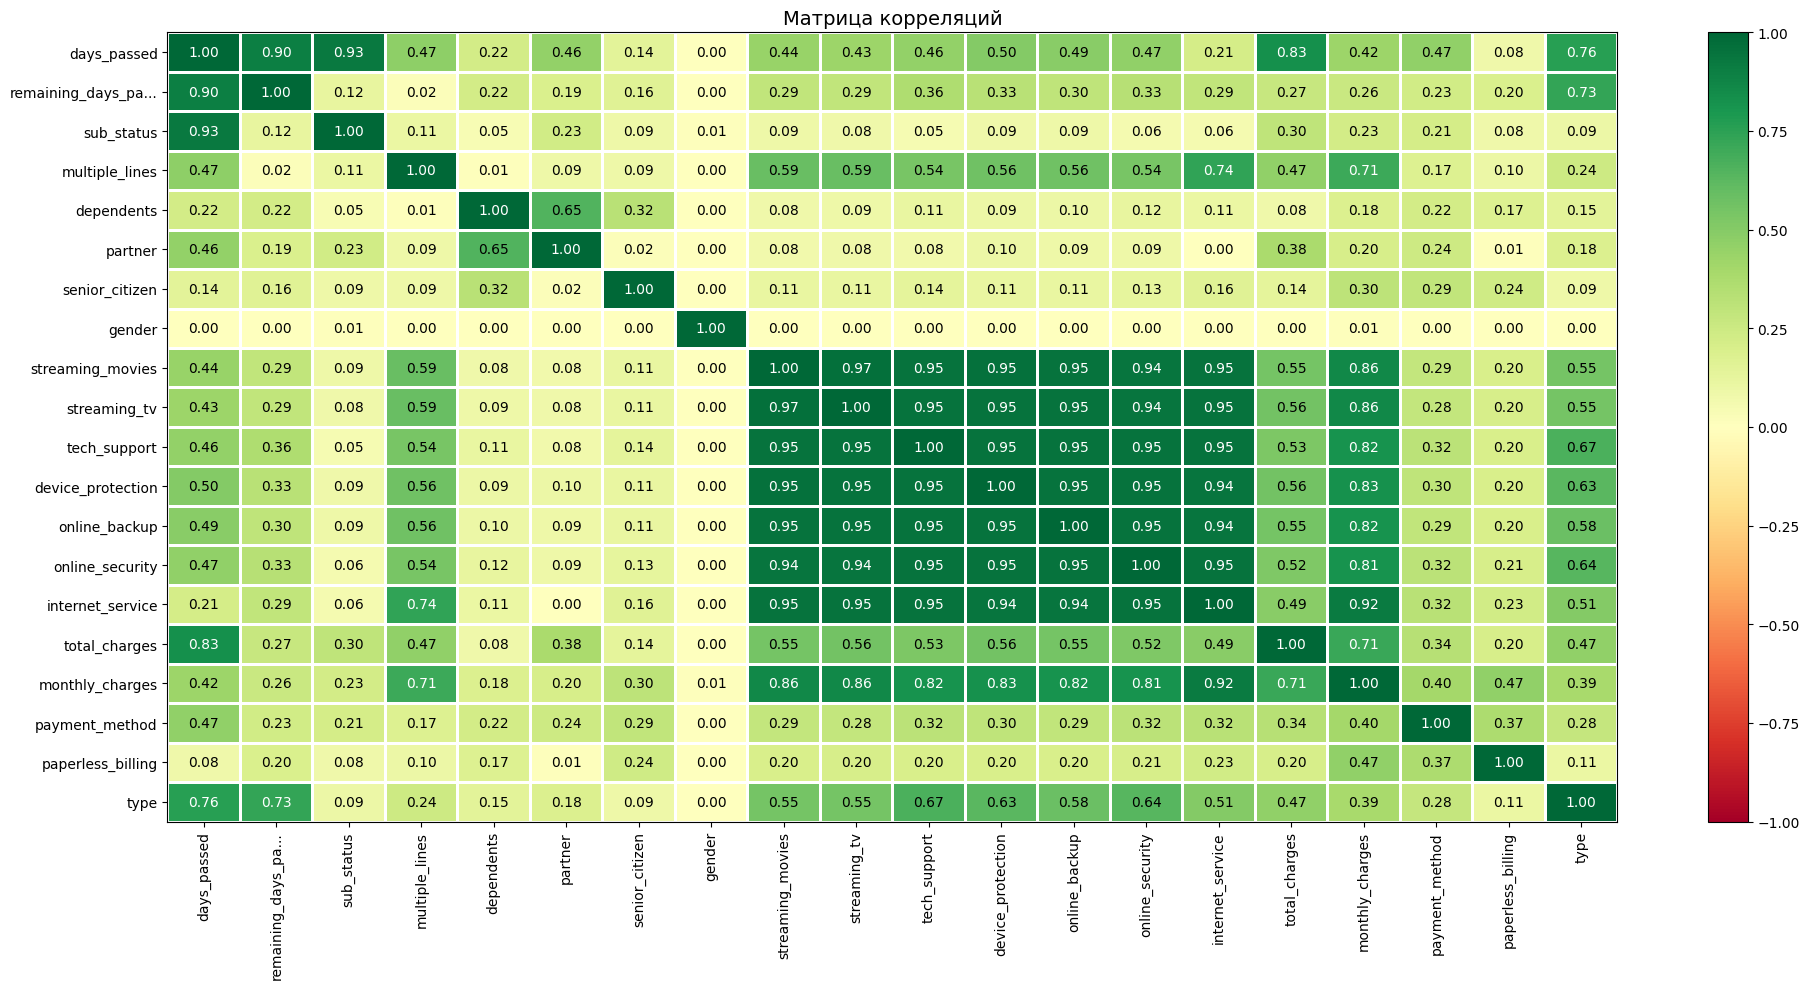

In [53]:
corr_matrix = phik_matrix(df_all_info, \
                          interval_cols=['remaining_days_payment', 'total_charges', 'monthly_charges', 'days_end'])

plot_correlation_matrix(corr_matrix.values, x_labels=corr_matrix.columns, \
                        y_labels=corr_matrix.index, title='Матрица корреляций', figsize=(20, 10))

Multicollinearity was also observed among the features `streaming_tv`, `streaming_movies`, `tech_support`, `device_protection`, `online_backup`, `online_security` and `internet_service`.

Let's remove the features that are highly correlated with each other. Let's leave only the one that correlates best with the target variable. This is the feature `streaming_movies`

In [54]:
df_all_info = df_all_info.drop(['gender', 'device_protection', 'online_backup', 'internet_service', 'streaming_tv', \
                                'tech_support', 'online_security'], axis=1)

### *Conclusion:*
- filled in the gaps in the features with out_of_service values ​​related to Internet services and telephony
- created the target feature sub_status based on the end_date column.
- created new input features, one of which will reflect the number of days remaining under the contract, and the other - how many days under the contract have already passed.
- removed the end_date and begin_date features to avoid leaks
- conducted an exploratory analysis of each feature
- conducted a correlation analysis as a result of which we removed the streaming_tv, tech_support, device_protection, online_backup, online_security and internet_service features, since there was multicollinearity between them, and they had almost no effect on the quality of the model. Removed the gender attribute, as it does not correlate with other attributes

**Preliminary portrait of the client who is most likely to terminate the contract:**

- payment type: 1 or 2 years
- payment type: bank transfer or credit card
- monthly expenses: about 85
- have a spouse
- actively used Internet or telephone services

## Data preparation

We split the data into test and training samples with mixing and stratification by the target feature to avoid class imbalance. 

In [55]:
warnings.filterwarnings('ignore')
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(df_all_info.drop('sub_status', axis=1), 
                                                    df_all_info['sub_status'], 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=df_all_info['sub_status'])

We select columns with quantitative and categorical features. We build pipelines for data preparation.

In [56]:
num_col = X_train.select_dtypes(include=['number']).columns.tolist()
cat_col = X_train.select_dtypes(include=['object']).columns.tolist()
print(f'num_col: {num_col},\n\ncat_col: {cat_col}')

num_col: ['monthly_charges', 'total_charges', 'remaining_days_payment', 'days_passed'],

cat_col: ['type', 'paperless_billing', 'payment_method', 'streaming_movies', 'senior_citizen', 'partner', 'dependents', 'multiple_lines']


In [57]:
num_pipe = Pipeline(
    [
        ('transformer', PowerTransformer()),
        ('scale', StandardScaler())
    ]
)

cat_pipe = Pipeline(
    [
        ('imputer_cat', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='out_of_service')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

Using ColumnTransformer

In [58]:
preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_col),
        ('cat', cat_pipe, cat_col)
    ], 
    remainder='passthrough'
)

Creating the final pipeline

In [59]:
pipe_final = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(random_state=RANDOM_STATE))
    ])

We write down models for enumeration.

In [60]:
param_grid_logistic = [
     {
        'model': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', \
                                     solver='liblinear')],
         'model__solver': ['liblinear', 'newton-cg'],
         'model__max_iter': [100, 200, 500],
         'preprocessor__num__scale': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


param_grid_tree = [
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__max_depth': range(5, 15),
        'model__max_features': range(10,20),
        'preprocessor__num__scale': ['passthrough'],
        'preprocessor__cat__encoder': [OrdinalEncoder(), 'passthrough']
    }
]

param_grid_catboost = [
    {
        'model': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)],
        'model__iterations': [50, 100, 200, 300, 400, 500],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'preprocessor__num__scale': ['passthrough'],
        'preprocessor__cat__encoder': [TargetEncoder(), 'passthrough']
    }
    
]

We will run the models separately through GridSearchCV

### *Conclusion:*
- split the data into training and test samples in a ratio of 1 to 3 with mixing and stratification by the target feature
- wrote down all the necessary pipelines for data preparation and model training

## Model training

### Logistic regression

In [61]:
search_log = GridSearchCV(pipe_final, param_grid_logistic, cv=5, scoring='roc_auc', n_jobs=-1)
search_log.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('transformer',
                                                                                          PowerTransformer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'remaining_days_payment',
                                                                          'days_passed']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer_cat',
                                                                                          SimpleImputer(fill_value='out_of_...
                                                                          'multiple_lines'])])),
                                       ('model',
                                        LogisticRegression(random_state=22072024))]),
             n_jobs=-1,
             param_grid=[{'model': [LogisticRegression(class_weight='balanced',
                                                       random_state=22072024,
                                                       solver='liblinear')],
                          'model__max_iter': [100, 200, 500],
                          'model__solver': ['liblinear', 'newton-cg'],
                          'preprocessor__num__scale': [StandardScaler(),
                                                       MinMaxScaler(),
                                                       'passthrough']}],
             scoring='roc_auc')

Parameters of the best model

In [62]:
search_log.best_params_ 

{'model': LogisticRegression(class_weight='balanced', random_state=22072024,
                    solver='liblinear'),
 'model__max_iter': 100,
 'model__solver': 'newton-cg',
 'preprocessor__num__scale': StandardScaler()}

ROC-AUC result on cross-validation on training set:

In [63]:
best_log = search_log.best_score_
best_log

0.7329549469235268

### Decision tree

In [64]:
search_tree = GridSearchCV(pipe_final, param_grid_tree, cv=5, scoring='roc_auc', n_jobs=-1)
search_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('transformer',
                                                                                          PowerTransformer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'remaining_days_payment',
                                                                          'days_passed']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer_cat',
                                                                                          SimpleImputer(fill_value='out_of_...
                                                                          'multiple_lines'])])),
                                       ('model',
                                        LogisticRegression(random_state=22072024))]),
             n_jobs=-1,
             param_grid=[{'model': [DecisionTreeClassifier(class_weight='balanced',
                                                           random_state=22072024)],
                          'model__max_depth': range(5, 15),
                          'model__max_features': range(10, 20),
                          'preprocessor__cat__encoder': [OrdinalEncoder(),
                                                         'passthrough'],
                          'preprocessor__num__scale': ['passthrough']}],
             scoring='roc_auc')

Parameters of the best model

In [65]:
search_tree.best_params_ 

{'model': DecisionTreeClassifier(class_weight='balanced', random_state=22072024),
 'model__max_depth': 7,
 'model__max_features': 12,
 'preprocessor__cat__encoder': OrdinalEncoder(),
 'preprocessor__num__scale': 'passthrough'}

ROC-AUC result on cross-validation on training set:

In [66]:
best_tree = search_tree.best_score_
best_tree

0.8003355364694184

### Boosting

In [67]:
search_catboost = GridSearchCV(pipe_final, param_grid_catboost, cv=5, scoring='roc_auc', n_jobs=-1)
search_catboost.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('transformer',
                                                                                          PowerTransformer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'remaining_days_payment',
                                                                          'days_passed']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer_cat',
                                                                                          SimpleImputer(fill_value='out_of_...
                                       ('model',
                                        LogisticRegression(random_state=22072024))]),
             n_jobs=-1,
             param_grid=[{'model': [<catboost.core.CatBoostClassifier object at 0x7f040884c070>],
                          'model__iterations': [50, 100, 200, 300, 400, 500],
                          'model__learning_rate': [0.01, 0.1, 0.2],
                          'preprocessor__cat__encoder': [TargetEncoder(),
                                                         'passthrough'],
                          'preprocessor__num__scale': ['passthrough']}],
             scoring='roc_auc')

Parameters of the best model

In [68]:
search_catboost.best_params_ 

{'model': <catboost.core.CatBoostClassifier at 0x7f040884c070>,
 'model__iterations': 500,
 'model__learning_rate': 0.2,
 'preprocessor__cat__encoder': TargetEncoder(),
 'preprocessor__num__scale': 'passthrough'}

ROC-AUC result on cross-validation on training set:

In [69]:
best_catboost = search_catboost.best_score_
best_catboost

0.9301134174885082

### *Conclusion:* 
We ran a hyperparameter and model search using GridSearchCV. We use the following models:

    - LogisticRegression()
    - DecisionTreeClassifier()
    - CatBoostClassifier()


## Choosing the best model

### Best model

We will display the indicators of the best models on the screen

In [70]:
results = pd.DataFrame({'roc-auc (train)': [best_log, best_tree, best_catboost],
                       'accuracy': [accuracy_score(y_test, search_log.predict(X_test)),\
                                   accuracy_score(y_test, search_tree.predict(X_test)),\
                                   accuracy_score(y_test, search_catboost.predict(X_test))]},
                       ['LogisticRegression', 'DecisionTreeClassifier', 'CatBoostClassifier'])

In [71]:
results.sort_values('roc-auc (train)', ascending=False)

,roc-auc (train),accuracy
CatBoostClassifier,0.930113,0.934696
DecisionTreeClassifier,0.800336,0.709824
LogisticRegression,0.732955,0.695060


It is obvious that the model **CatBoostClassifier(iterations=500, learning_rate=0.2, random_state=22072024)** copes best with the task

This model has a better ROC-AUC indicator for cross-validation on the training set.

The result of the best model on the test sample.

In [72]:
roc_auc_score(y_test, search_catboost.predict_proba(X_test)[:,-1])

0.9184289734491617

The result satisfies the required value roc-auc>=0.85

### Roc-auc curve and error matrix

Let's build a ROC curve

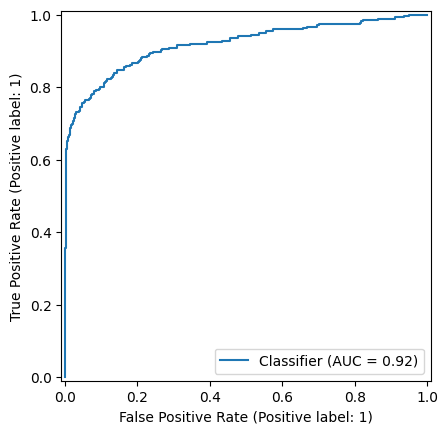

In [73]:
RocCurveDisplay.from_predictions(y_test, search_catboost.predict_proba(X_test)[:, 1]);

Let's create an error matrix

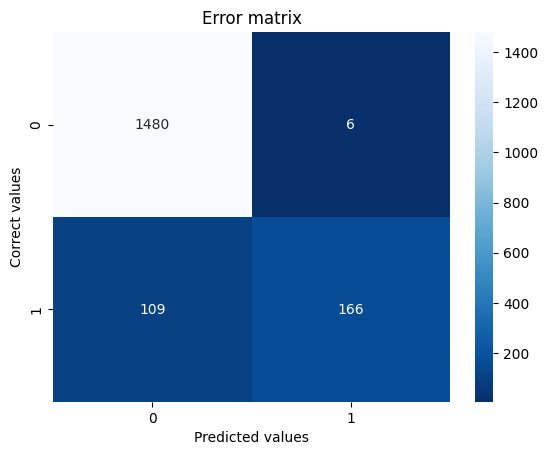

In [74]:
sns.heatmap(confusion_matrix(y_test, search_catboost.predict(X_test)), annot=True, fmt='d', cmap='Blues_r');
plt.title('Error matrix')
plt.ylabel('Correct values')
plt.xlabel('Predicted values');

Judging by the ROC curve and the error matrix, the False Negative and False Positive indicators are low. Remember that these indicators were especially important to the customer, which means that our model more than copes with the task.

### Evaluation of the importance of features

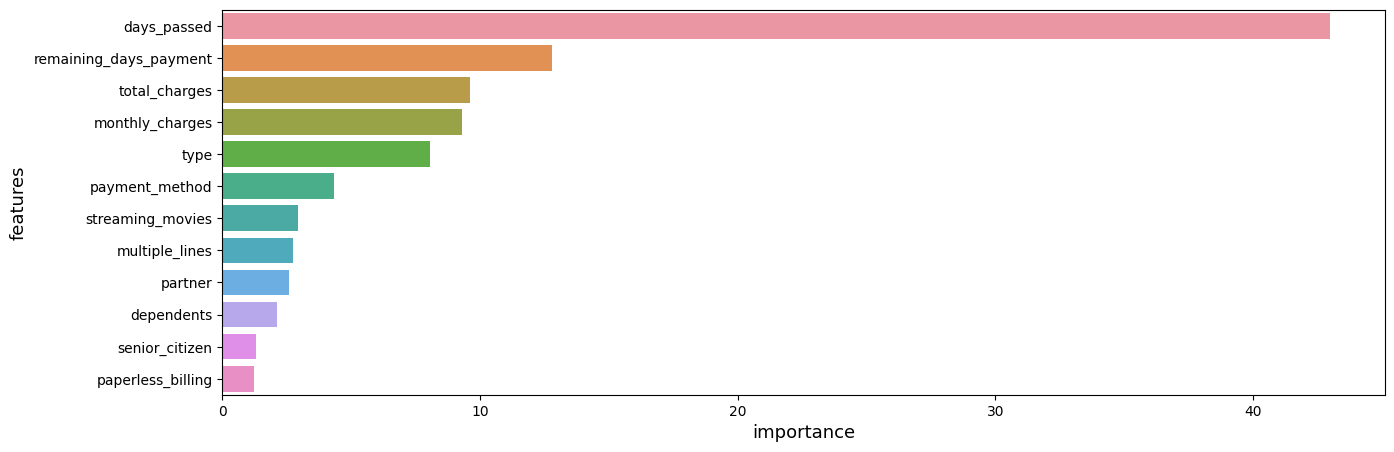

In [75]:
table_importance = (pd.DataFrame(search_catboost.best_estimator_[-1].feature_importances_, num_col + cat_col)
                    .sort_values(by=0, ascending=False)
                    .reset_index()
                   )

plt.figure(figsize=(15, 5));
sns.barplot(x=table_importance[0], y=table_importance['index']);
plt.xlabel('importance', fontsize=13);
plt.ylabel('features', fontsize=13);

The most important feature was `days_passed`.

Name of conditions: "paperless_billing" and "pensioner_citizen".

### *Conclusion:*
- selected the best model: CatBoostClassifier(iterations=500, learning_rate=0.2, random_state=22072024). Its roc-auc indicators on the test sample: 0.918
- built a ROC curve and an error matrix. Confirmed that False Positive and False Negative errors are not significant
- analyzed the importance of features.

## Final conclusion:

    Main task:

        Train a model to predict customer churn based on the provided data.

    Work stages:
    Step 1. Data loading:
        - unloaded data
        - conducted their initial inspection
        - brought the column names to the snake_case style.
    Step 2. Exploratory analysis and data preprocessing
        - checked the data for correctness
        - checked the data for duplicates
        - replaced spaces in the `total_charges` attribute with the corresponding values ​​in the `total_changes` column, since the customers are new
    Step 3. Data merging
        - merged all tables by cusomer_id.
    Step 4. Exploratory analysis and preprocessing of the combined dataframe data
        - filled in the gaps in the features with out_of_service values ​​related to Internet services and telephony
        - created a target feature sub_status based on the end_date column
        - created new input features, one of which will reflect the number of days remaining under the contract, and the other - how many days under the contract have already passed
        - removed the end_date and begin_date features to avoid leakage
        - conducted an exploratory analysis of each feature
        - conducted a correlation analysis, as a result of which we removed the gender feature, since it does not correlate with other features, and also removed streaming_tv, tech_support, device_protection, online_backup, online_security and internet_service, since there was multicollinearity between them, and they almost did not affect the quality of the model
    Step 5. Data preparation
        - split the data into training and test samples in a ratio of 1 to 3 with mixing and stratification by target feature
        - wrote down all necessary pipelines for data preparation and model training
    Step 6. Machine learning model training
        - using GridSearchCV, trained the following models:
            * LogisticRegression()
            * DecisionTreeClassifier()
            * CatBoostClassifier()
    Step 7. Choosing the best model
        - having compared the best models of each type by three indicators: roc-auc on the training sample, roc-auc on the test sample and accuracy, we concluded that the CatBoostClassifier model copes with the task best (iterations=500, learning_rate=0.2, random_state=22072024). Its roc-auc indicator on the test sample: 0.9184289734491617
        - built a ROC curve and an error matrix. Convinced that False Positive and False Negative errors are not significant
        - analyzed the importance of features.

**Best model: CatBoostClassifier(iterations=500, learning_rate=0.2, random_state=22072024)**



### Recommendations for businesses:

During the research analysis of the data, interesting patterns were noticed:
- clients with the One year or Two year payment type are more likely to terminate the contract (22-21% of clients)
- clients who use Bank Transfer or Credit Card as payment are also more likely to terminate the contract (21% of clients)
- clients who actively use additional services (Internet services or telephony) are more likely to terminate the contract
- clients who terminated the contract paid more per month on average than clients who did NOT terminate the contract. About 70 on average for those who did NOT terminate and about 85 for those who did, with the peak for those who terminated being at 100.
- clients with a spouse are more likely to terminate the contract than clients without a significant other. (21% of clients)

Therefore, recommendations were developed for businesses:
- develop special offers for clients with the 1 or 2 year payment type to extend their contracts. For example, discounts when renewing the contract or free months of service.
- Offer promotional codes and discounts to customers who use a bank or credit card for payments to encourage them to continue using the service.
- Introduce a loyalty program for customers who actively use Internet or telephony services. Offer bonuses for long-term use.
- Develop reward programs for customers with high monthly expenses (around 85). These can be discounts, free services or exclusive offers.
- Develop family rates and service packages for customers who have a spouse. For example, a reduced monthly payment.
- Introduce packages that include Internet and telephony at more favorable prices to retain customers who actively use these services.
- Improve the quality of customer service, especially for customers who may be prone to terminating the contract. Quick and effective resolution of customer problems can reduce their desire to leave.
